Loading Women's Data (Analyzing Participation in Decisions)...

--- Summary Results: Women's Participation in Decisions (%) ---
                   Own health care  Major household purchases  \
Rwamagana                       93                         91   
Nyagatare                       72                         67   
Gatsibo                         90                         84   
Kayonza                         92                         90   
Kirehe                          74                         74   
Ngoma                           89                         87   
Bugesera                        80                         74   
East Province                   84                         80   
Rwanda (National)               82                         78   

                   Visits to family/relatives  
Rwamagana                                  96  
Nyagatare                                  81  
Gatsibo                                    92  
Kayonza                      

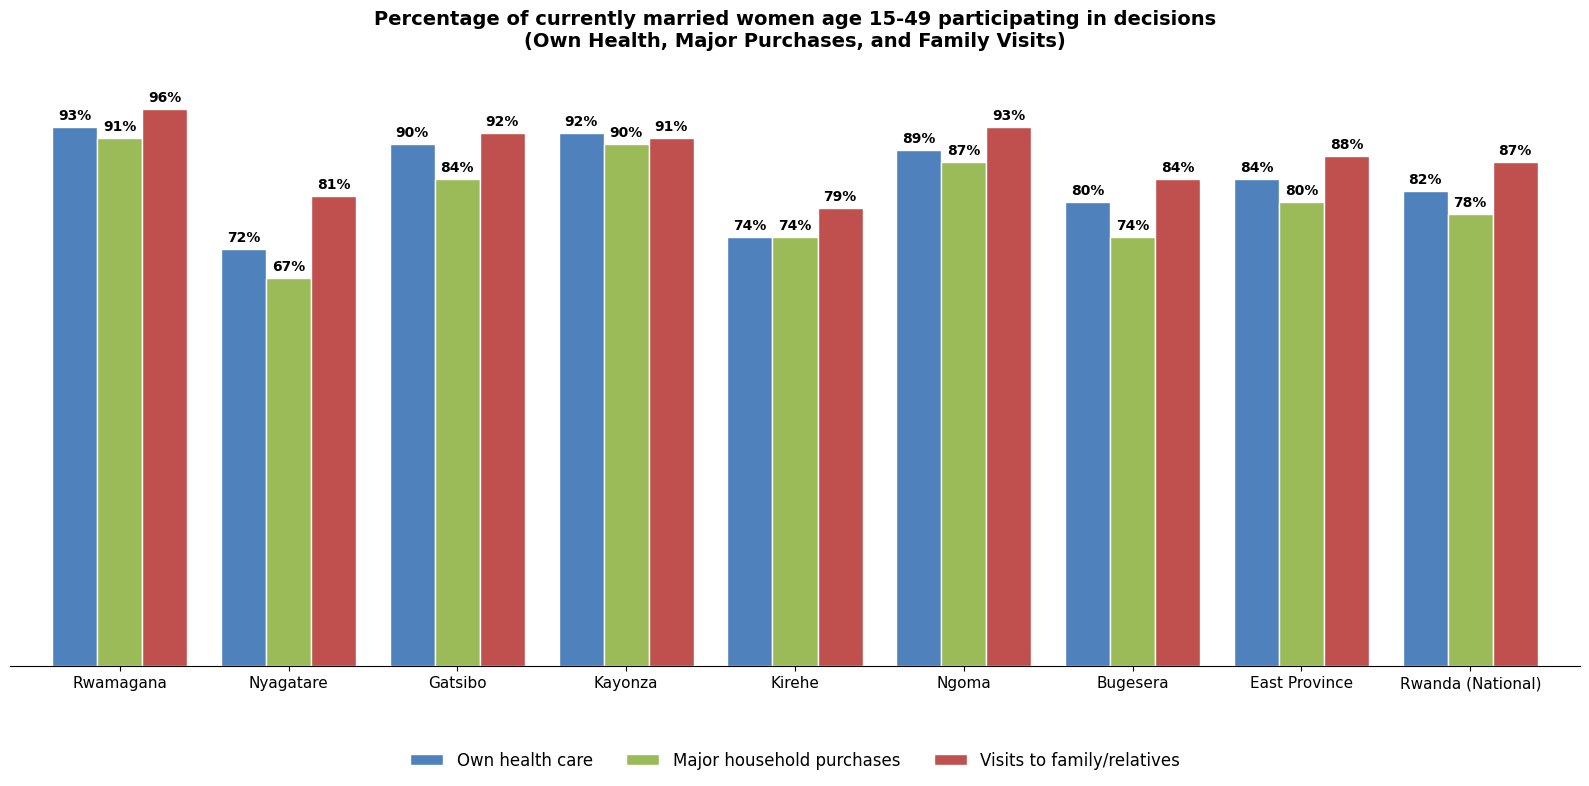

In [1]:
#!/usr/bin/env python3
# dhs_women_participation_decisions.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# The three standard DHS decision indicators
INDICATORS = {
    "own_health": "Own health care",
    "major_purchases": "Major household purchases",
    "family_visits": "Visits to family/relatives"
}

# Colors matching typical decision-making charts
COLORS = ["#4F81BD", "#9BBB59", "#C0504D"]

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    return int(math.floor(n + 0.5))

def get_participation_stats(df):
    """Calculates weighted % of women participating in each decision."""
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return pd.Series({lbl: 0 for lbl in INDICATORS.values()})
    
    # Logic: Participates if code is 1 (Self) or 2 (Jointly)
    health = np.average(df['v743a'].isin([1, 2]), weights=df['w']) * 100
    purchases = np.average(df['v743b'].isin([1, 2]), weights=df['w']) * 100
    visits = np.average(df['v743d'].isin([1, 2]), weights=df['w']) * 100
    
    return pd.Series({
        "Own health care": standard_round(health),
        "Major household purchases": standard_round(purchases),
        "Visits to family/relatives": standard_round(visits)
    })

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Women's Data (Analyzing Participation in Decisions)...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- ACCURACY FILTERS ---
    # 1. Currently Married (v502 == 1)
    df = df[df['v502'] == 1].copy()

    # Weights
    df['w'] = pd.to_numeric(df['v005']) / 1000000.0
    
    # District Picker
    dist_col = next((c for c in ['sdistrict', 'sdstr'] if c in df.columns), 'v001')

    # Force numeric on indicator columns
    for col in ['v743a', 'v743b', 'v743d', dist_col]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(9)

    # --- AGGREGATION ---
    results = {}
    df_east = df[df['v024'] == 5].copy()
    
    for code, name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == code]
        results[name] = get_participation_stats(subset)

    # Totals
    results["East Province"] = get_participation_stats(df_east)
    results["Rwanda (National)"] = get_participation_stats(df)

    final_df = pd.DataFrame(results).T
    print("\n--- Summary Results: Women's Participation in Decisions (%) ---")
    print(final_df)

    # --- JSON OUTPUT ---
    with open("eastern_women_participation_decisions.json", "w") as f:
        json.dump(final_df.to_dict(orient='index'), f, indent=4)

    # --- PLOTTING (Grouped Bar Chart) ---
    ax = final_df.plot(kind="bar", figsize=(16, 8), color=COLORS, width=0.8, edgecolor="white")

    plt.title("Percentage of currently married women age 15-49 participating in decisions\n(Own Health, Major Purchases, and Family Visits)", 
              fontsize=14, fontweight='bold', pad=25)
    
    plt.xticks(rotation=0, fontsize=11)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)
    
    plt.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=3, fontsize=12)

    # Add numeric labels (integers)
    for c in ax.containers:
        ax.bar_label(c, fmt='%d%%', padding=3, fontsize=10, fontweight="bold")

    plt.tight_layout()
    plt.savefig("Women_Decision_Making.png", dpi=300)
    print("✅ Success! Results saved.")